# Анализ оттока клиентов фитнес-центра
### Задача
Сеть фитнес-центров разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. 
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 
Чтобы бороться с оттоком, отдел по работе с клиентами перевёл в электронный вид множество анкет пользователей. Задача — провести анализ и подготовить план действий по удержанию клиентов.

### Оглавление

<a id="contents"></a>

* [Шаг 1. Загрузить данные и ознакомиться.](#dataset)
* [Шаг 2. Исследовательский анализ данных (EDA).](#analitics)
    * [Средние значения и стандартные отклонения.](#mean)
    * [Средние значения признаков в двух группах — ушел / остался.](#mean_group)
    * [Столбчатые гистограммы - ушел / остался.](#hist_group)
    * [Матрица корреляций](#matrix)
* [Шаг 3. Модель прогнозирования оттока пользователей.](#predict)    
* [Шаг 4. Кластеризация пользователей.](#cluster)    
    * [Стандартизация.](#standartization)
    * [Матрица расстояний и дендрограмма](#dendrogramm)
    * [K-means](#k_means)
    * [Средние значения признаков для кластеров](#cl_means)
    * [Распределения признаков для кластеров](#cl_hist)
* [Шаг 5. Выводы и базовые рекомендации по работе с клиентами](#final)

<a id="dataset"></a>
##### Шаг 1. Загрузить данные и ознакомиться

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
import warnings
warnings.simplefilter("ignore")
from IPython.core.display import display, HTML
# На всю ширину экрана
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
df = pd.read_csv('/datasets/gym_churn.csv')
df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


###### Описание данных
**Набор данных включает следующие поля:**  
'Churn' — факт оттока в текущем месяце - целевая переменная;  
Текущие поля в датасете:  
**Данные пользователя за предыдущий до проверки факта оттока месяц:**  
'gender' — пол  
'Near_Location' — проживание или работа в районе, где находится фитнес-центр  
'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)  
'Phone' — наличие контактного телефона  
'Age' — возраст  
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)  
**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента**  
'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)  
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)  
'Group_visits' — факт посещения групповых занятий  
'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц  
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон  

* [Оглавление](#contents)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В датасете имеем 4000 записей - каждая запись данные о клиентах в 14-ти признаках, один из них - целевая переменная.  
Формат данных - все колонки числовые, пропусков нет.

<a id="analitics"></a>
##### Шаг 2. Исследовательский анализ данных (EDA)

<a id="mean"></a>
Посмотрим на распределения признаков для всех данных.

In [5]:
display(df.describe())
print('Абонементы по длительности \n', df['Contract_period'].value_counts())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Абонементы по длительности 
 1     2207
12     960
6      833
Name: Contract_period, dtype: int64


Мужчин и женщин примерно поровну 51% и 49%;  
84.5% клиентов живут или работают в районе где находится фитнес-центр;  
48.6% клиентов имеют скидки, как сотрудники партнеров клуба;  
30.8% пришли в клуб по акции "приведи друга;  
90.3% в анкете указали свой номер телефона;  
больше половины действующих абонементов(2207 шт) длительностью 1 месяц остальные распределены почти поровну: 833шт полугодовые и 960 шт годовых;  
41.2% клиентов посещают групповые занятия;  
средний возраст клиента - 29 лет, минимальный - 18, максимальный - 41;  
отток составил 26,5% клиентов за отчетный месяц.  
  
Визуализируем распределение бинарных признаков.

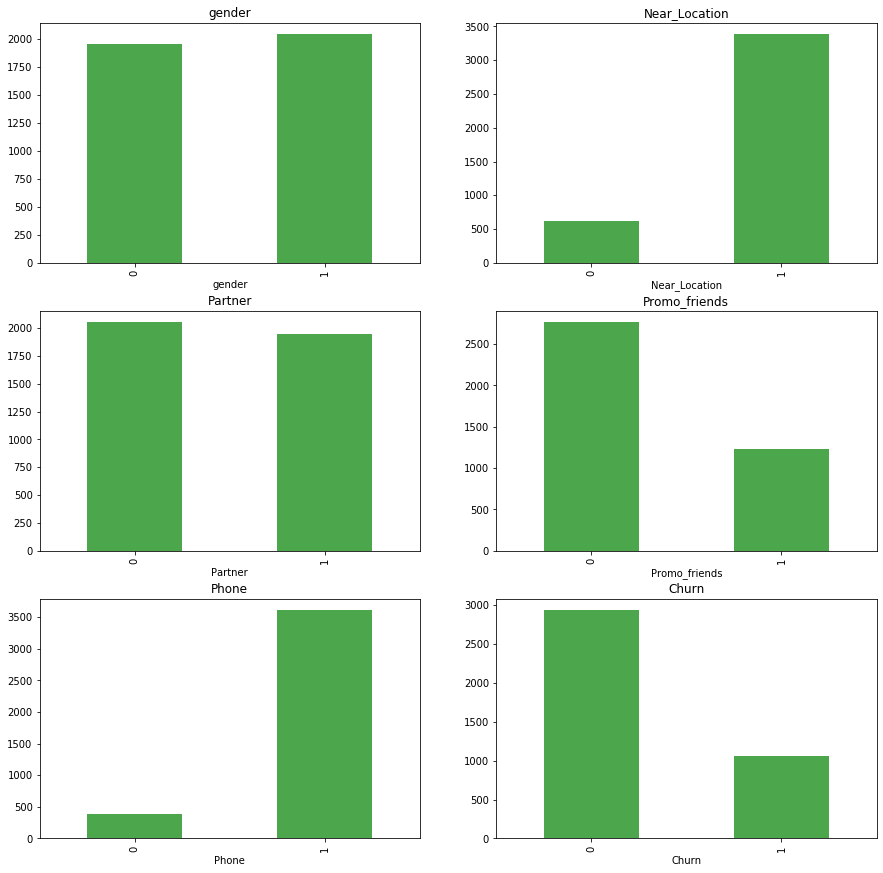

In [6]:
binary = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Churn']
fig, ax = plt.subplots(nrows = 3, ncols = 2)
ax = ax.ravel()
place = 0
for feature in binary:
    df.groupby(feature)['Age'].count().plot(kind = 'bar', figsize = (15, 15), ax = ax[place], color = 'g', alpha=0.7)
    ax[place].set_title(feature)
    place += 1

* [Оглавление](#contents)

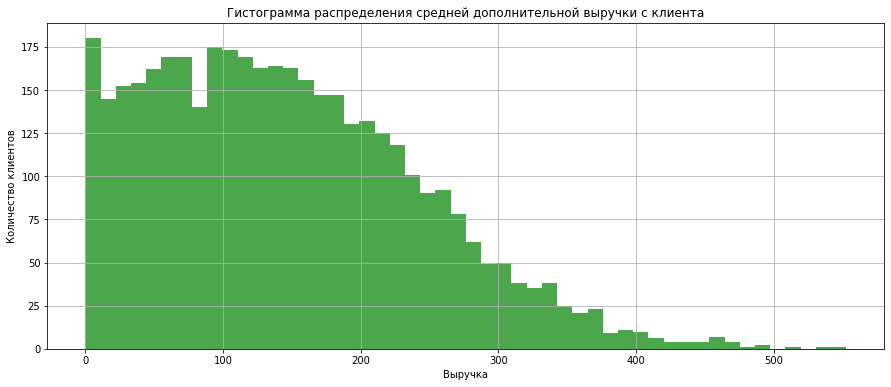

In [7]:
df['Avg_additional_charges_total'].hist(bins = 50, figsize=(15,6), color = 'g', alpha=0.7)
plt.title('Гистограмма распределения средней дополнительной выручки с клиента')
plt.xlabel('Выручка')
plt.ylabel('Количество клиентов')
plt.show()

Распределение средней выручки имеет скошенность вправо.

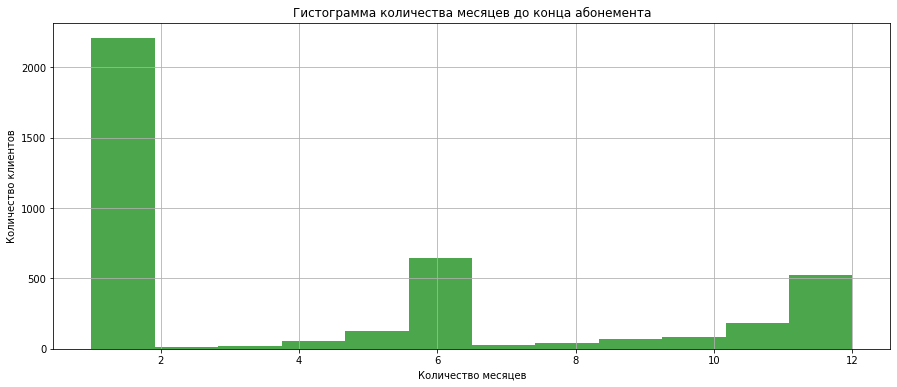

In [8]:
df['Month_to_end_contract'].hist(bins=12, figsize=(15,6), color = 'g', alpha=0.7)
plt.title('Гистограмма количества месяцев до конца абонемента')
plt.xlabel('Количество месяцев')
plt.ylabel('Количество клиентов')
plt.show()

Явно видно преобладание коротких абонементов. Так же выделяются новые абонементы на 6 и 12 мес. В отчетном периоде продано абонементов больше чем  ранее. Можно предположить, что клуб недавно открылся и еще нет множества клиентов с действующими абонементами. Но мы знаем, что есть клиенты со значением Lifetime = 30. Тогда возможно сейчас действует какая-то акция, и под нее пришло много новеньких.

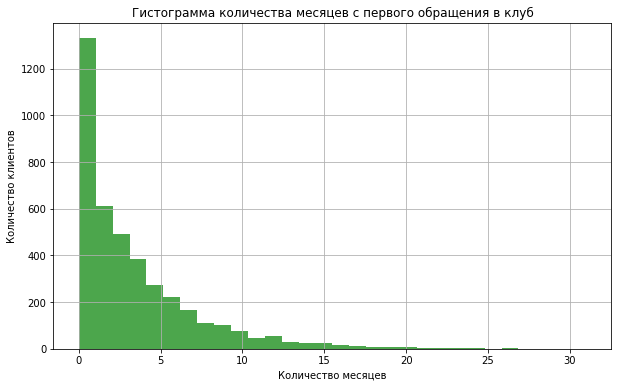

In [9]:
df['Lifetime'].hist(bins=30, figsize=(10,6), color = 'g', alpha=0.7)
plt.title('Гистограмма количества месяцев с первого обращения в клуб')
plt.xlabel('Количество месяцев')
plt.ylabel('Количество клиентов')
plt.show()

Очень мало постоянных клиентов, которые с клубом более года. Серьезный отток.

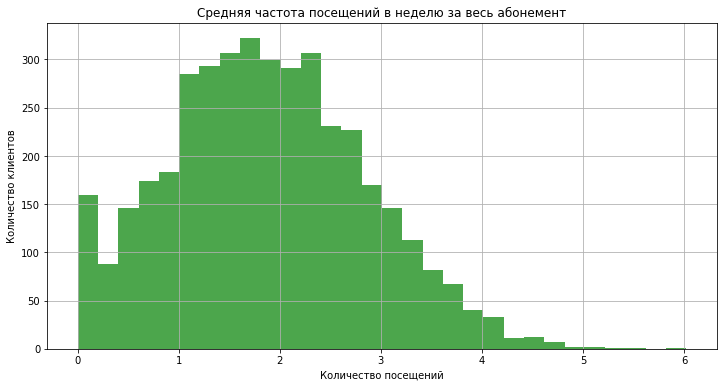

In [10]:
df['Avg_class_frequency_total'].hist(bins = 30, figsize=(12,6), color = 'g', alpha=0.7)
plt.title('Средняя частота посещений в неделю за весь абонемент')
plt.xlabel('Количество посещений')
plt.ylabel('Количество клиентов')
plt.show()

Закономерно самые часто встречающиеся значения от 1 до 3 раз в неделю. Более 150 клиентов не пришли в зал ни разу.   
Этот признак должен сильно отличаться при группировке по оттоку.

* [Оглавление](#contents)

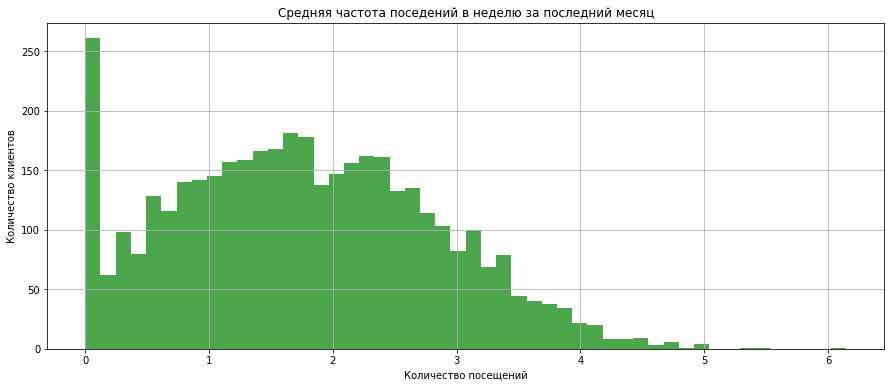

In [11]:
df['Avg_class_frequency_current_month'].hist(bins = 50, figsize=(15,6), color = 'g', alpha=0.7)
plt.title('Средняя частота поседений в неделю за последний месяц')
plt.xlabel('Количество посещений')
plt.ylabel('Количество клиентов')
plt.show()

В отчетном месяце количесто ни разу не пришедших уже более 250 человек. Похоже и правда действуют серьезные скидки ))

<a id="mean_group"></a>
###### Сравним средние значения признаков с разбивкой по статусу клиента (ушел / не ушел)

In [12]:
churn = df.groupby('Churn').mean().round(2).T
churn.columns = ['Остался', 'Ушел']
churn

,Остался,Ушел
gender,0.51,0.51
Near_Location,0.87,0.77
Partner,0.53,0.36
Promo_friends,0.35,0.18
Phone,0.90,0.90
Contract_period,5.75,1.73
Group_visits,0.46,0.27
Age,29.98,26.99
Avg_additional_charges_total,158.45,115.08
Month_to_end_contract,5.28,1.66


У клиентов попавших в отток меньше средний чек за доп. услуги,  
они реже посещали клуб и в течение всего абонемента и за последний месяц,  
меньше ходили на групповые занятия,  
из ушедших только 18% пришли к нам по программе "приведи друга", 36% имели партнерские скидки.  
Большинство из ужедших пробыли с нами не более 1 месяца

<a id="hist_group"></a>
##### Строим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

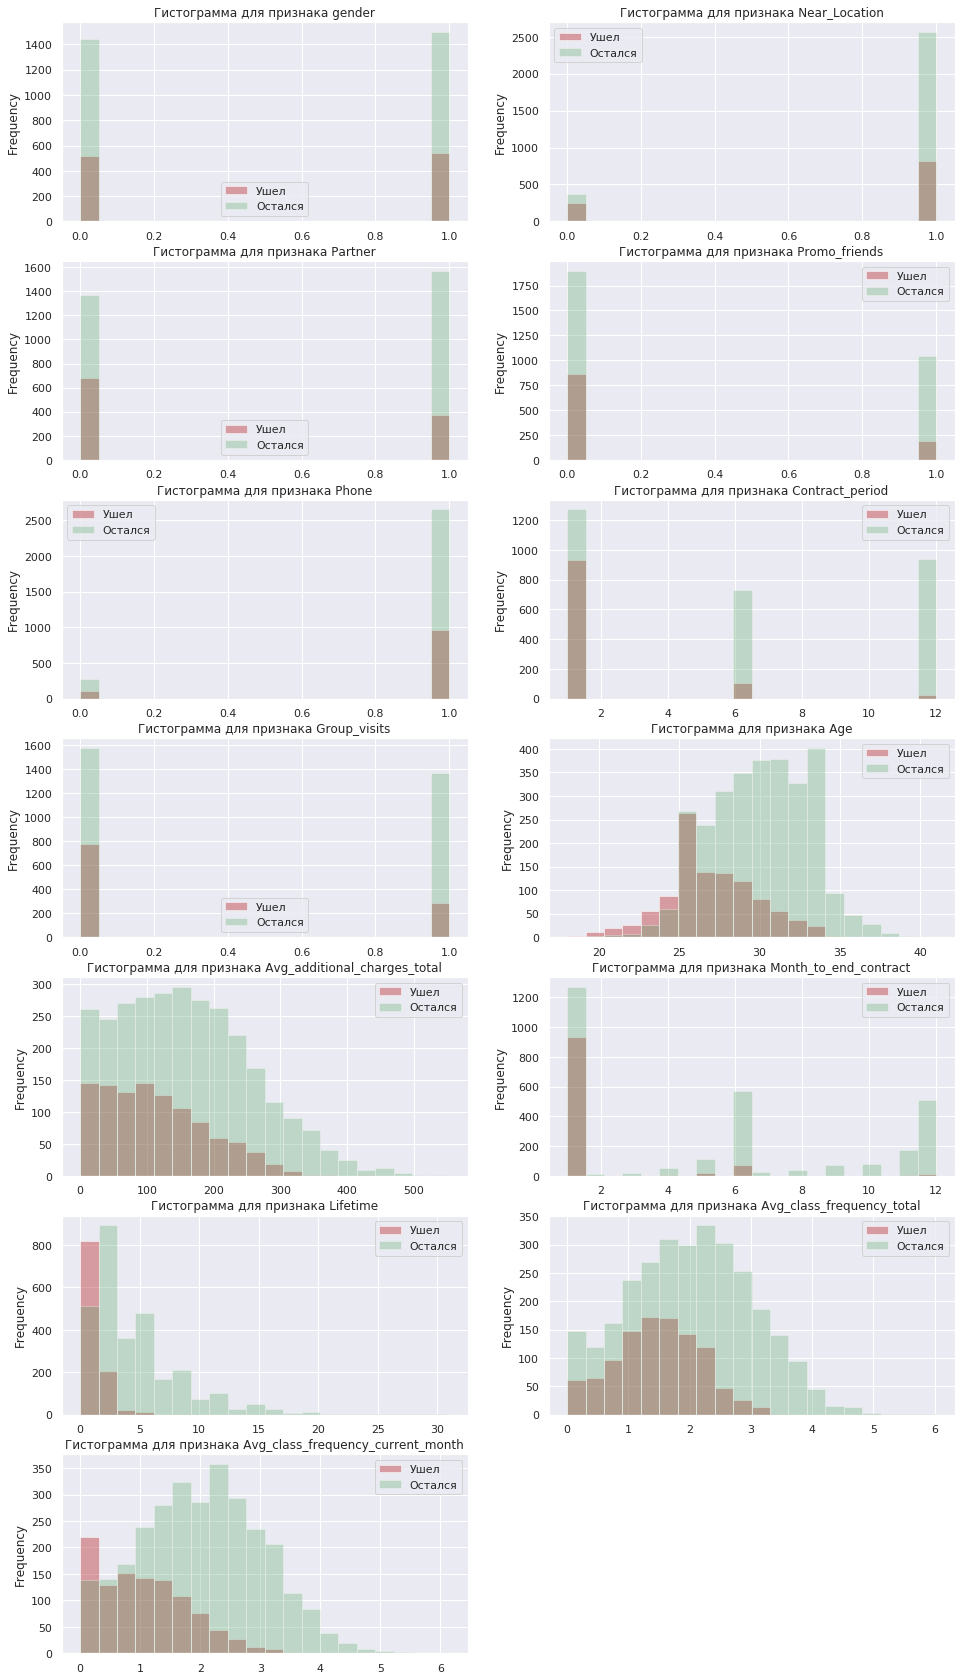

In [13]:
sns.set()
fig, ax = plt.subplots(nrows = 7, ncols = 2)
ax = ax.ravel()
ax[-1].set_visible(False)
place = 0
for i in df.drop('Churn', axis = 1).columns:
    range_hist = (df[i].min(), df[i].max())
    df.query('Churn == 1')[i].\
            plot(kind = 'hist', y = 'column', bins = 20, grid = True,\
                figsize = (16,30), color = 'r', label='Ушел',\
                 legend=True, alpha=0.5, range = range_hist, ax = ax[place])
        
    df.query('Churn == 0')[i].\
    plot(kind='hist', bins=20, grid = True,\
     color = 'g', label= 'Остался',\
     legend=True, alpha=0.3, range = range_hist, ax = ax[place])
    
    ax[place].set_title('Гистограмма для признака ' + i)
    
    place += 1
plt.show()

**По гистограммам делаем следующие выводы:**  
распределение полов такое же как и в общем количестве клиентов 50/50 (`gender`);  
тех, кто живет рядом ушло меньше, чем осталось почти втрое (`Near_Location`);  
участники партнерской программы (`Partner`) у нас в общем количестве клиентов преобладают, а в оттоке их меньше, чем тех кто не участник;  
участников промо-программы "приведи друга" (`Promo_friends`) ушло значительно меньше чем "не участников";  
телефоны оставляют почти все, предварительно можно сказать, что ML **этот признак будет не значителен**;  
большинство ушедших клиентов имеют абонементы на 1 месяц (так может они еще вернутся));  
из ужеджих большинство не посещало групповые занятия (`Group_visits`);  
возраст ушедших клиентов немного меньше, и почему-то сильно выделяются 25-ти летние;  
гистограммы пользования дополнительными услугами (`Avg_additional_charges_total`) у ушедших и оставшихся практически одинаковые, скорее всего этот признак для ML тоже **не будет иметь большого веса**;  
те, кто с нами более 5 месяцев (`Lifetime`) гораздо более преданны, ушедших значительно больше из тех, кто занимался менее 1 месяца;  
те кто покинул нас, ходили на занятия в среднем реже, чем оставшиеся (`Avg_class_frequency`).

* [Оглавление](#contents)

<a id="matrix"></a>
###### Строим матрицу корреляций

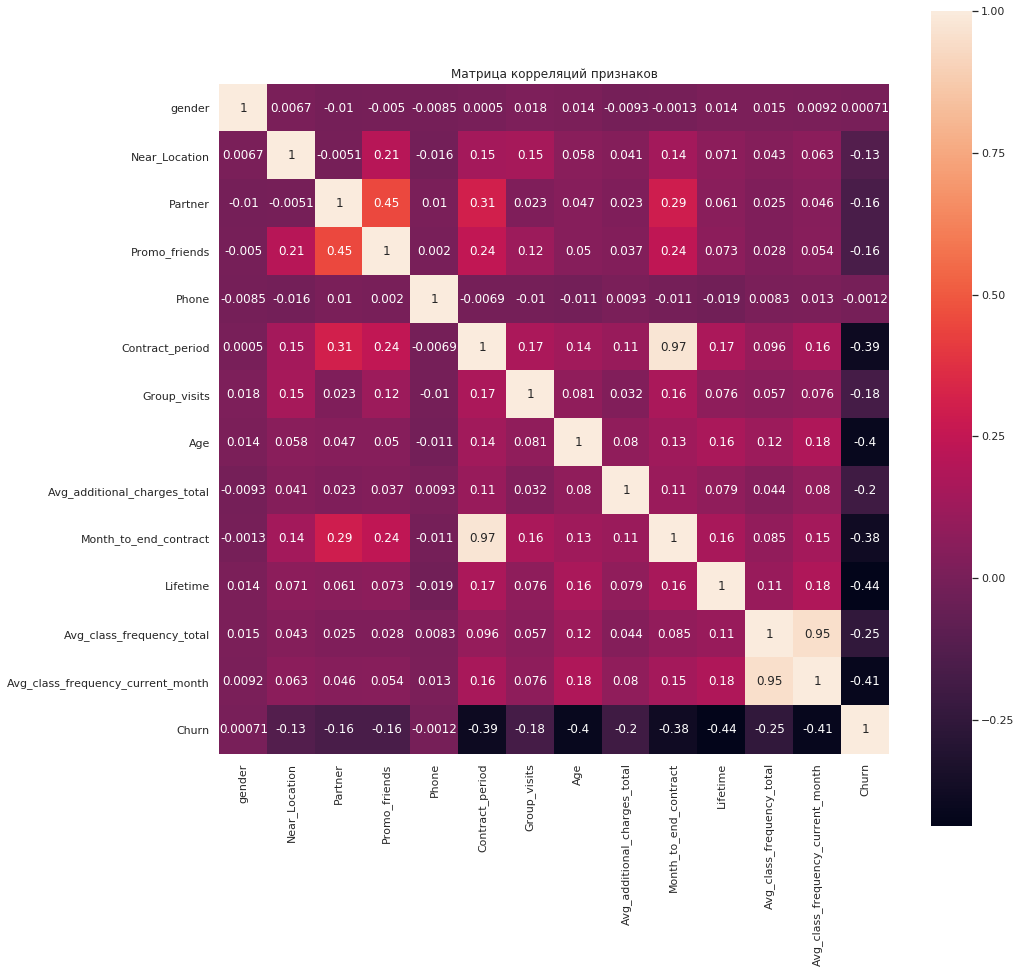

In [14]:
matrix = df.corr()
plt.figure(figsize = (15,15))
sns.heatmap(matrix, square = True, annot = True)
plt.title('Матрица корреляций признаков')
plt.show()

Признаков, которые сильно коррелируют нет, за исключением тех, что основаны на одних и тех же данных (в разных масштабах).  
Относительно целевой переменной можно отметить повышенную обратную корреляцию срока абонемента, возраста, жизненного цикла и количества занятий в неделю.  
Немного выделяются цифры по партнерской программе в паре с длительностью абонемента.

* [Оглавление](#contents)

<a id="predict"></a>
##### Шаг 3. Строим модель прогнозирования оттока пользователей.

Разделим наши данные на признаки (матрица X) и целевую переменную (y)

In [15]:
X = df.drop(columns = ['Churn'])
y = df['Churn']

Разделяем модель на обучающую и валидационную выборку

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

Задаем алгоритмы для логистической регрессии и случайного леса

In [17]:
models = [LogisticRegression(random_state = 42), RandomForestClassifier(n_estimators = 100, random_state = 42)]

Создаем функцию, которая принимает на вход модель и данные и выводит метрики.

In [18]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f} '.format(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)))

В цикле обучаем модели и получаем предсказание от каждой модели.

In [19]:
for i in models:
    print(i)
    print()
    make_prediction(i, X_train, y_train, X_test, y_test)
    print()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:0.92 Precision:0.89 Recall:0.80 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Accuracy:0.91 Precision:0.85 Recall:0.78 



Логистическая регрессия показала себя лучше во всем трем "видам спорта"

* [Оглавление](#contents)

<a id="cluster"></a>
##### Шаг 4. Делаем кластеризацию пользователей

Для задачи кластеризации берем нашу матрицу признаков **Х**  
<a id="standartization"></a>
Стандартизируем данные.

In [20]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(X) # обучаем нормализатор и преобразуем набор данных

Взглянем на стандартизированные данные.

In [21]:
print(x_sc[:3])

[[ 0.97970588  0.42788074  1.02686062  1.49716101 -3.05985201  0.28989014
   1.19403206 -0.0565538  -1.37753121  0.16160501 -0.19332863 -1.91191971
  -1.67847198]
 [-1.0207145   0.42788074 -0.973842   -0.66793083  0.32681319  1.60882159
   1.19403206  0.55732732 -0.35021325  1.83194105  0.87368001  0.04517569
   0.1360137 ]
 [-1.0207145   0.42788074  1.02686062 -0.66793083  0.32681319 -0.8092194
  -0.83749845 -0.36349436 -0.1815923  -0.79287273 -0.46008079 -0.02049263
  -0.02901851]]


In [22]:
linked = linkage(x_sc, method = 'ward')
linked

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.38725499e+01, 2.65600000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89563592e+01, 3.03400000e+03],
       [7.99200000e+03, 7.99700000e+03, 1.04627601e+02, 4.00000000e+03]])

<a id="dendrogramm"></a>
Визуализируем таблицу связок `linked` в виде дендрограммы.

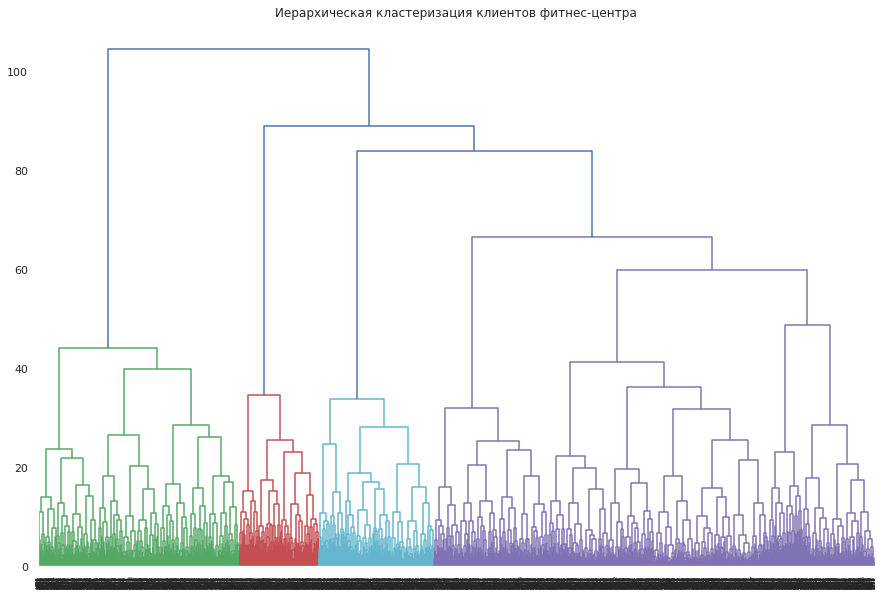

In [23]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-центра')
plt.show()

На основании полученного графика можно выделить 4 кластера клиентов фитнес центра.

<a id="k_means"></a>
Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [24]:
km = KMeans(n_clusters = 5) # задаём число кластеров, равное 5 согласно заданию.
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров

<a id="cl_means"></a>
Сохраняем метки кластера в поле нашего датасета и выводим статистику по средним значениям наших признаков по кластеру

In [25]:
df['cluster'] = labels
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.500000,0.484051,0.564516,0.493590,0.523316
Near_Location,0.936636,0.722488,0.849078,0.948718,0.862694
Partner,0.740783,0.295853,0.279954,0.814103,0.471503
Promo_friends,0.480415,0.011164,0.071429,0.998397,0.305699
Phone,1.000000,1.000000,1.000000,1.000000,0.000000
Contract_period,11.827189,1.922648,2.670507,3.022436,4.777202
Group_visits,0.547235,0.275917,0.450461,0.435897,0.427461
Age,29.892857,28.129187,30.033410,29.067308,29.297927
Avg_additional_charges_total,163.426463,129.367977,161.130058,141.294953,144.208179
Month_to_end_contract,10.785714,1.829346,2.470046,2.831731,4.466321


По результатам кластеризации мы видим явное выделение в отдельные кластеры клиентов, которые:  
- не живут в шаговой доступности,  
- не оставили номер телефона,  
- имеют самый долгосрочный абонемент, соответственно и больший срок до окончания абонемента,
- в большинстве пользуются "партнеркой"

Средние значения по остальным признакам распределены довольно равномерно.  
  
Построим распределения признаков для кластеров. Так же как раньше - в цикле.
<a id="cl_hist"></a>

* [Оглавление](#contents)

In [27]:
df.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn', 'cluster'],
      dtype='object')

In [28]:
binary = ['gender', 'Near_Location', 'Partner', 'Group_visits', 'Promo_friends', 'Phone', 'Churn', 'Contract_period']

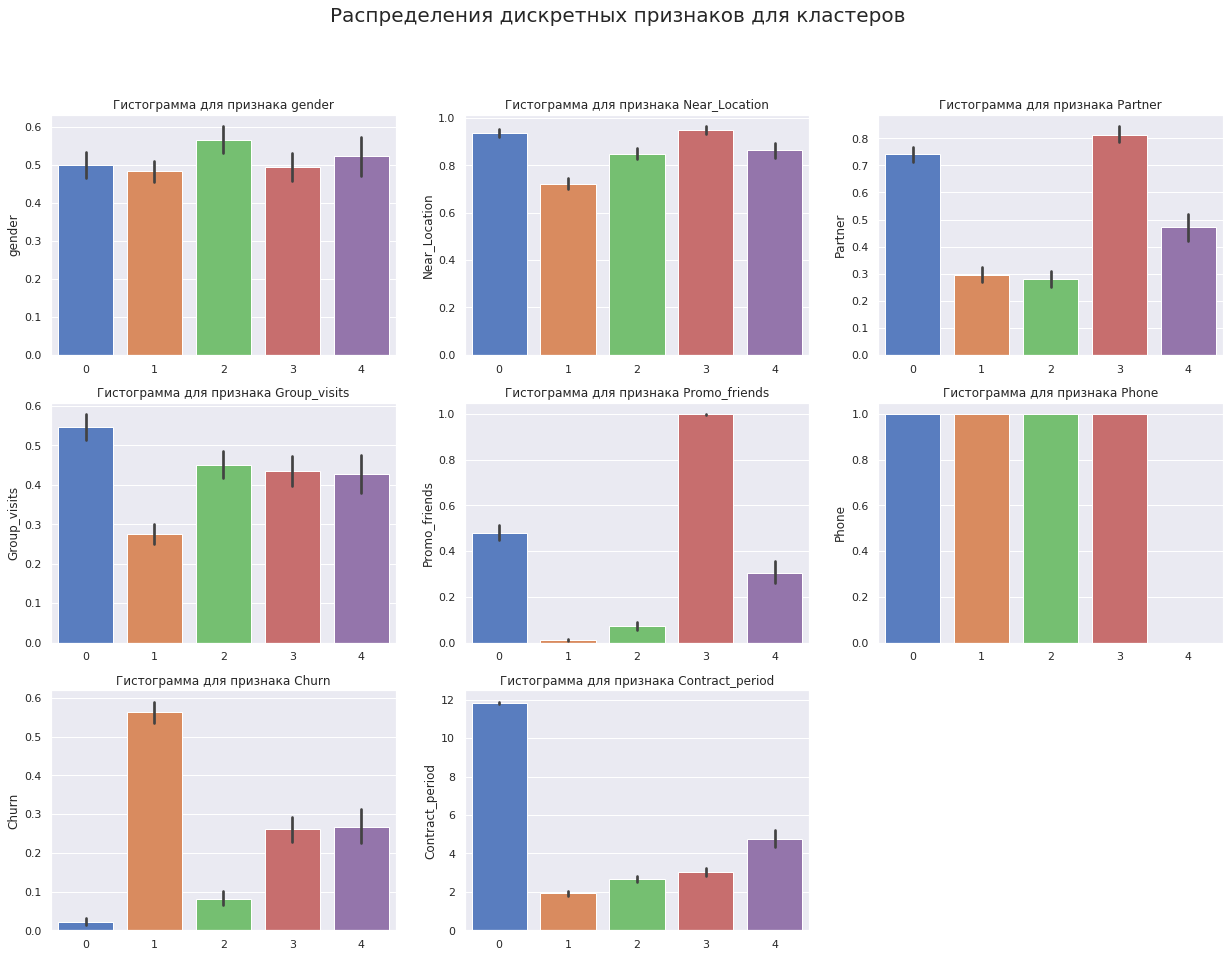

In [29]:
sns.set_palette("muted")
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (21, 15))
ax = ax.ravel()
ax[-1].set_visible(False)

place = 0
for i in binary:
    sns.barplot(x='cluster', y=i, data=df, ax = ax[place])
    ax[place].set(title='Гистограмма для признака ' + i)
    fig.suptitle('Распределения дискретных признаков для кластеров', fontsize = 20)
    ax[place].set(xlabel=None)
    place += 1
plt.show()

In [30]:
numbers = ['Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',\
           'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

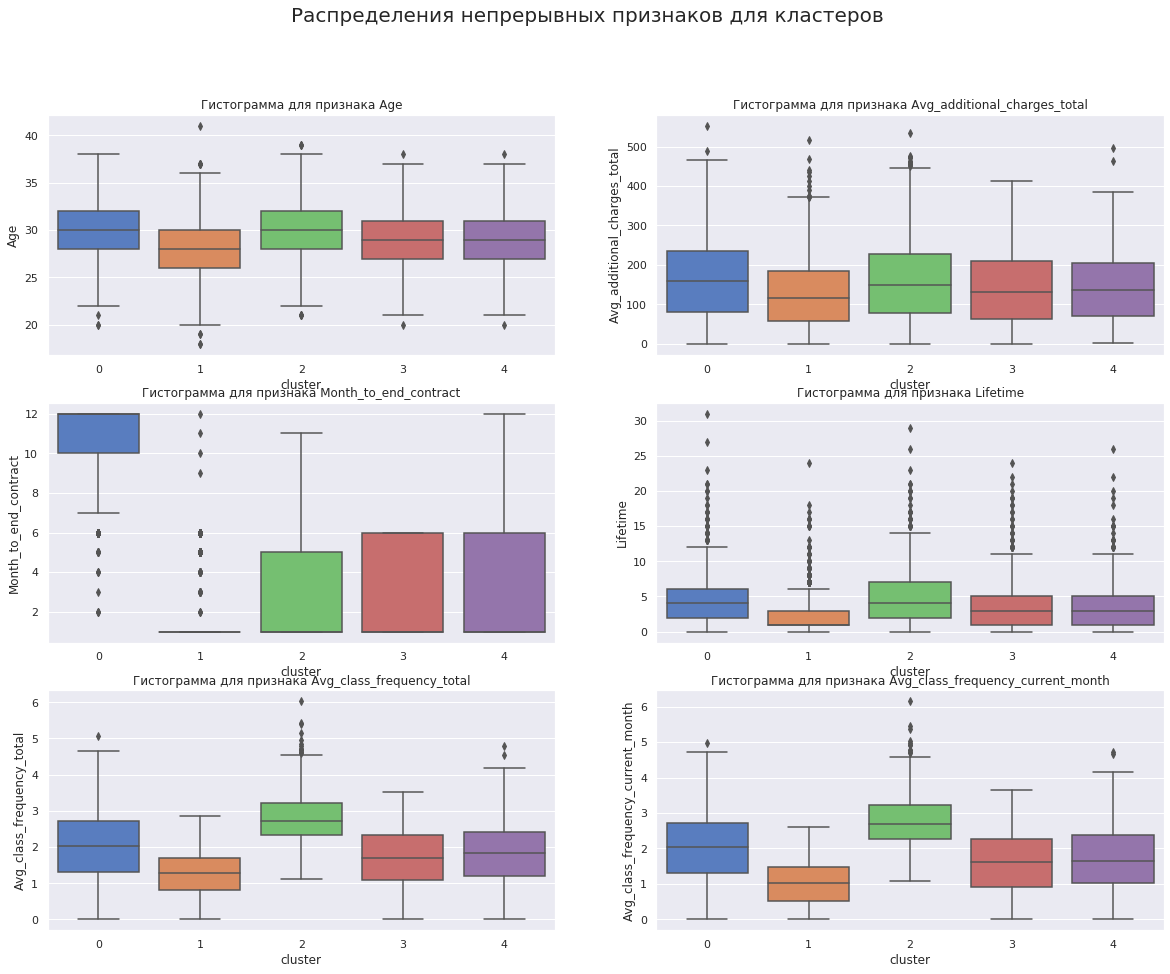

In [31]:
sns.set_palette("muted")
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 15))
ax = ax.ravel()
place = 0
for i in numbers:
    sns.boxplot(x='cluster', y=i, data=df, ax = ax[place])
    ax[place].set_title('Гистограмма для признака ' + i)
    fig.suptitle('Распределения непрерывных признаков для кластеров', fontsize = 20)
    place += 1
plt.show()

Рассмотрим графики и охарактеризуем кластеры:  
  
0 - все живут рядом с фитнес-центром, мало кто мользуется "партнеркой", на групповые занятия ходят менее половины, короткие абонементы, минимальный Lifetime, самые редкие посещения.
**самый максимальный отток**  
  
1 - ничем не примечателен, только в среднем самые частые посечения в неделю.  
**небольшой отток**  
  
2 - в этом кластере почти 80% по партнерской программе, больше всех ходят на групповые занятия, больше всего клиентов по промо "приведи друга", самые долгие абонементы, соответственно и максимальные сроки до окончания абонемента.  
**самый минимальный отток**  
  
3 - ничем не примечателен, кроме того что сюта попали те, кто не оставил номер телефона.  
**отток средний**  
  
4 - никто не живет рядом, меньше всех посещают групповые, меньше всего промо "приведи друга", короткие абонементы, Lifetime №2 с конца.  
**№2 по оттоку**  
  
Возраст по всем кластерам распределился примерно одинаково. Траты на дополнительные услуги судя по медианному  значениюво всех кластерах в пределах 100 - 160 у.е.

* [Оглавление](#contents)

Напрашивается вывод о сильном влиянии срока абонемента на отток, но я бы не стал делать далекоидущие выводы о минимальном оттоке людей с максимальными сроками абонементов. У нас во всем датафрейме преобладают короткие абонементы, следовательно именно они составляют основную массу оттока.

Для каждого полученного кластера отдельно посчитаем долю оттока.

In [32]:
df.groupby('cluster')['Churn'].mean()

cluster
0    0.021889
1    0.562201
2    0.081797
3    0.261218
4    0.266839
Name: Churn, dtype: float64

У нас получилось два кластера с небольшой долей оттока и два с оттоком около 50%

<a id="final"></a>
##### Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

Основные параметры для прогнозирования оттока Lifetime и количество посещений в неделю, причем большее значение имеет частота занятий за последний месяц, а не за весь период.  
Следовательно, если мы отмечаем, что клиент стал реже приходить за последний месяц, есть смысл поинтересоваться, что случилось, может быть мы сможем повлиять на ситуацию.  
Lifetime напрямую зависит от длительности абонемента - следует мотивировать клиентов на покупку более длительных абонементов. Можно предложить скидку на Длительный абонемент по окончании короткого.  

Можно предлагать скидки на дополнительные услуги за регулярное посещение, обозначить какое-то количество тренировок как KPI.  
  
"Партнерка" работает - В кластере с наименьшим оттоком максимальное число клиентов в "партнерке". Надо расширять пул компаний партнеров.  
  
Большинство клиентов живут рядом с фитнес-центром и надо быть готовым, что ежемесячно половина тех, кто живет далеко, будет "отваливаться", что ни предлагай. Хотя, можно обратить внимание на то, они почти не пользуются "promo_friends" и придумать что-то в этом направлении, а еще большинство из "далеких" не ходят на групповые занятия, кого-то можно будет удержать заинтересовав этой услугой.

* [Оглавление](#contents)